In [74]:
import keras
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Activation
from keras.utils.vis_utils import plot_model
from IPython.display import clear_output
from keras import optimizers
from keras.models import load_model

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, linear_model, preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline


In [75]:
features = ['MIP', 'SIP','EKIP','SKIP','MDM-SR','SDM-SR','EKDM-SR','SKDM-SR','Target']
df =  pd.read_csv('pulsar_stars.csv',
                names=features,na_values='?',header=None, skiprows = 1)
df = df.dropna()
df.head(6)

,MIP,SIP,EKIP,SKIP,MDM-SR,SDM-SR,EKDM-SR,SKDM-SR,Target
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0
5,93.570312,46.698114,0.531905,0.416721,1.636288,14.545074,10.621748,131.394004,0


In [76]:

#pulsar = np.array((df.loc[:,'MIP':'Target']))
# Get the appropriate data from the datafile using the column headers
pulsar_x= np.array((df.loc[:,'MIP':'SKDM-SR']))
pulsar_y= np.array((df.loc[:,'Target']))

# Reshape the features and target vector
pulsar_x=pulsar_x.reshape(pulsar_x.shape[0],8)
pulsar_y=pulsar_y.reshape(pulsar_y.shape[0],1)

# Check the shape
print(pulsar_x.shape)
print(pulsar_y.shape)


(17898, 8)
(17898, 1)


In [77]:
# Scale the features, mean center and standard deviation = 1
x_scale = preprocessing.scale(pulsar_x)

# Default test size of 0.25 of dataset, default shuffle=true, 
x_train, x_test, y_train, y_test = train_test_split(x_scale, pulsar_y)
y_train = y_train.reshape((y_train.shape[0]), 1)

#Check the shape 
print(y_train.shape)
print(x_train.shape)

(13423, 1)
(13423, 8)


# Neural Networks
In the following section, we will run our data set through various neural networks with different hyper parameters. We will vary the activation function (tanh, reLU, sigmoid), the number of inputs in the hidden layer (10, 100, 200), and the number of hidden layers (1, 2, 5, with 100 nodes in each hidden layer). Weights and biases will be initialized randomly.  

In [78]:
# Build and compile our network with user given parameters
def neural_network(nin, nh, nout, nhl, act):
    model = Sequential();
    for x in range(0,nhl):
        model.add(Dense(nh, input_shape=(nin,), activation=act, name="hidden"+str(x)))
    model.add(Dense(nout, activation="sigmoid", name="output"))  
    # Compile model
    opt = optimizers.Adam(lr=0.001) 
    model.compile(optimizer=opt, 
             loss="binary_crossentropy",
             metrics=["accuracy"])  
    return model

# Train and validate our network on training and test data
def train_network(model, x_train, y_train, x_test, y_test):
    history = model.fit(x_train, y_train, epochs=10, batch_size=100, 
                validation_data=(x_test, y_test), verbose=0)
    return history

# Plot network accuracy
def plot_acc(history, title):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.show()

# Plot network loss
def plot_loss(history, title):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['acc', 'val_acc'], loc='upper right')
    plt.show()

# Network 8-100-1, Sigmoid

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden0 (Dense)              (None, 100)               900       
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


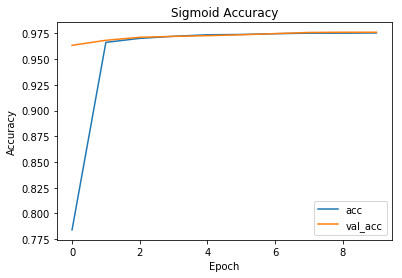

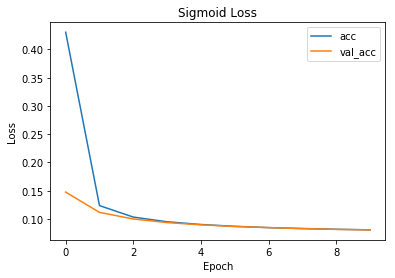

Accuracy = 0.976089


In [79]:
K.clear_session()

modelArr = []
historyArr = []
modelNameArr = []
# Number of nodes in input layer = number of features = 8
nin = x_train.shape[1];
# Number of hidden layer nodes
nh = 100;
# Number of output nodes
nout = 1;


model_sig = neural_network(nin, nh, nout, 1, "sigmoid")
sig_history = train_network(model_sig, x_train, y_train, x_test, y_test);
model_sig.summary()
plot_acc(sig_history, "Sigmoid Accuracy")
plot_loss(sig_history, "Sigmoid Loss")

modelArr.append(model_sig)
historyArr.append(sig_history)
modelNameArr.append("model_sig")

score, acc = model_sig.evaluate(x_test, y_test, verbose = 0)
print("Accuracy = %f" % acc)


## Network 8-100-1, ReLU

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden0 (Dense)              (None, 100)               900       
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


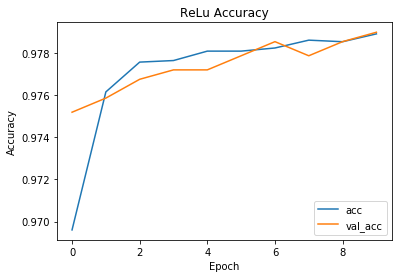

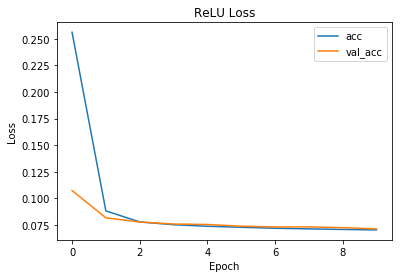

Accuracy = 0.978994


In [80]:
nh = 100;
    
model_relu = neural_network(nin, nh, nout, 1, "relu")
model_relu.summary()
relu_history = train_network(model_relu, x_train, y_train, x_test, y_test);
plot_acc(relu_history, "ReLu Accuracy")
plot_loss(relu_history, "ReLU Loss")

modelArr.append(model_relu)
historyArr.append(relu_history)
modelNameArr.append("model_relu")

score, acc = model_relu.evaluate(x_test, y_test, verbose = 0)
print("Accuracy = %f" % acc)

## Network 8-100-1, tanh

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden0 (Dense)              (None, 100)               900       
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


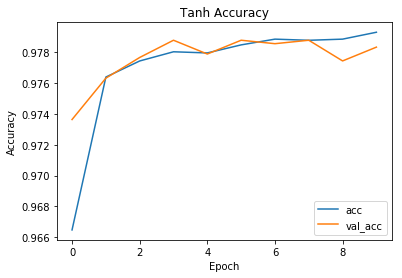

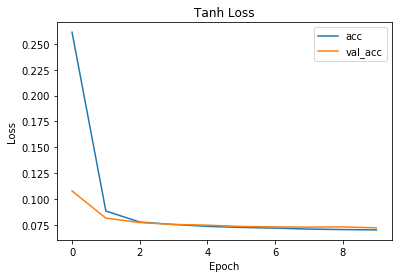

Accuracy = 0.978324


In [81]:
nh = 100;
    
model_tanh = neural_network(nin, nh, nout, 1, "relu")
model_tanh.summary()
tanh_history = train_network(model_tanh, x_train, y_train, x_test, y_test);
plot_acc(tanh_history, "Tanh Accuracy")
plot_loss(tanh_history, "Tanh Loss")

modelArr.append(model_tanh)
historyArr.append(tanh_history)
modelNameArr.append("model_tanh")

score, acc = model_tanh.evaluate(x_test, y_test, verbose = 0)
print("Accuracy = %f" % acc)

## Network 8-10-1, sigmoid

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden0 (Dense)              (None, 10)                90        
_________________________________________________________________
output (Dense)               (None, 1)                 11        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


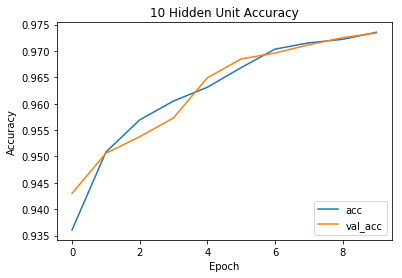

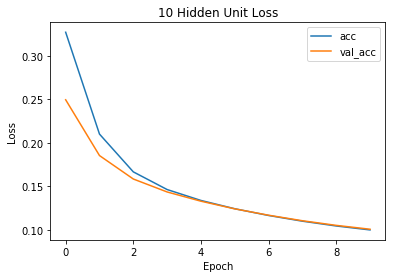

Accuracy = 0.973408


In [82]:
# We are changing the number of hidden units here
nh = 10;
    
model_ten = neural_network(nin, nh, nout, 1, "sigmoid")
model_ten.summary()
ten_history = train_network(model_ten, x_train, y_train, x_test, y_test);
plot_acc(ten_history, "10 Hidden Unit Accuracy")
plot_loss(ten_history, "10 Hidden Unit Loss")

modelArr.append(model_ten)
historyArr.append(ten_history)
modelNameArr.append("model_ten")

score, acc = model_ten.evaluate(x_test, y_test, verbose = 0)
print("Accuracy = %f" % acc)

## Network 8-200-1, sigmoid

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden0 (Dense)              (None, 200)               1800      
_________________________________________________________________
output (Dense)               (None, 1)                 201       
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


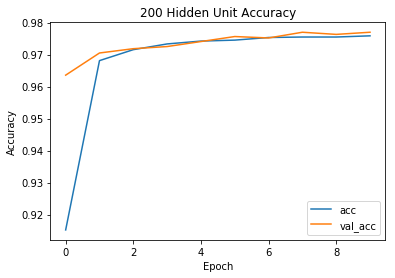

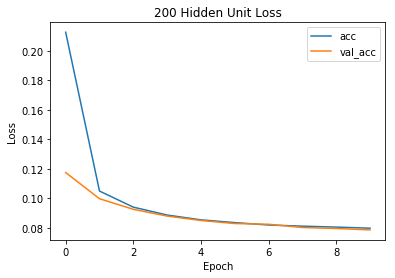

Accuracy = 0.976983


In [83]:
nh = 200;
    
model_twohund = neural_network(nin, nh, nout, 1, "sigmoid")
model_twohund.summary()
twohund_history = train_network(model_twohund, x_train, y_train, x_test, y_test);
plot_acc(twohund_history, "200 Hidden Unit Accuracy")
plot_loss(twohund_history, "200 Hidden Unit Loss")

modelArr.append(model_twohund)
historyArr.append(twohund_history)
modelNameArr.append("model_twohund")

score, acc = model_twohund.evaluate(x_test, y_test, verbose = 0)
print("Accuracy = %f" % acc)

## Network 8-100-100-1 sigmoid

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden0 (Dense)              (None, 100)               900       
_________________________________________________________________
hidden1 (Dense)              (None, 100)               10100     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 11,101
Trainable params: 11,101
Non-trainable params: 0
_________________________________________________________________


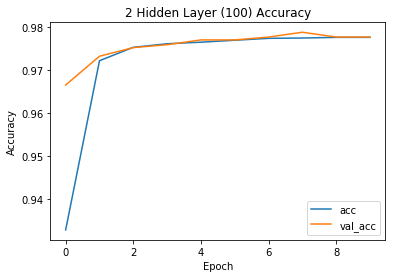

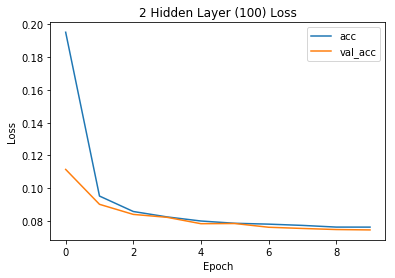

Accuracy = 0.977654


In [84]:
nh = 100;
num_layers = 2;
    
model_twolayer = neural_network(nin, nh, nout, num_layers, "sigmoid")
model_twolayer.summary()
twolayer_history = train_network(model_twolayer, x_train, y_train, x_test, y_test);
plot_acc(twolayer_history, "2 Hidden Layer (100) Accuracy")
plot_loss(twolayer_history, "2 Hidden Layer (100) Loss")

modelArr.append(model_twolayer)
historyArr.append(twolayer_history)
modelNameArr.append("model_twolayer")

score, acc = model_twolayer.evaluate(x_test, y_test, verbose = 0)
print("Accuracy = %f" % acc)

## Network 8-100-100-100-100-100-1, sigmoid

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden0 (Dense)              (None, 100)               900       
_________________________________________________________________
hidden1 (Dense)              (None, 100)               10100     
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
hidden3 (Dense)              (None, 100)               10100     
_________________________________________________________________
hidden4 (Dense)              (None, 100)               10100     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 41,401
Trainable params: 41,401
Non-trainable params: 0
_________________________________________________________________


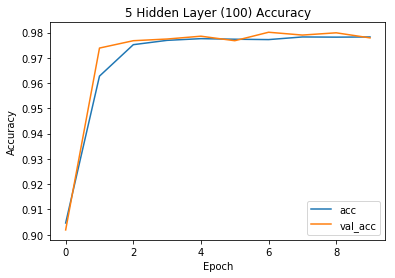

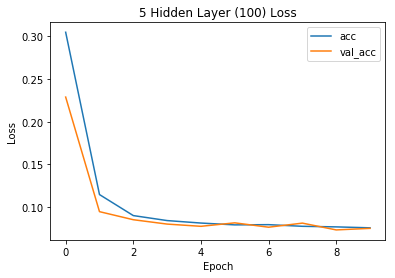

Accuracy = 0.977877


In [85]:
nh = 100;
num_layers = 5;
    
model_fivelayer = neural_network(nin, nh, nout, num_layers, "sigmoid")
model_fivelayer.summary()
fivelayer_history = train_network(model_fivelayer, x_train, y_train, x_test, y_test);
plot_acc(fivelayer_history, "5 Hidden Layer (100) Accuracy")
plot_loss(fivelayer_history, "5 Hidden Layer (100) Loss")

modelArr.append(model_fivelayer)
historyArr.append(fivelayer_history)
modelNameArr.append("model_fivelayer")

score, acc = model_fivelayer.evaluate(x_test, y_test, verbose = 0)
print("Accuracy = %f" % acc)

## Accuracy of All Models

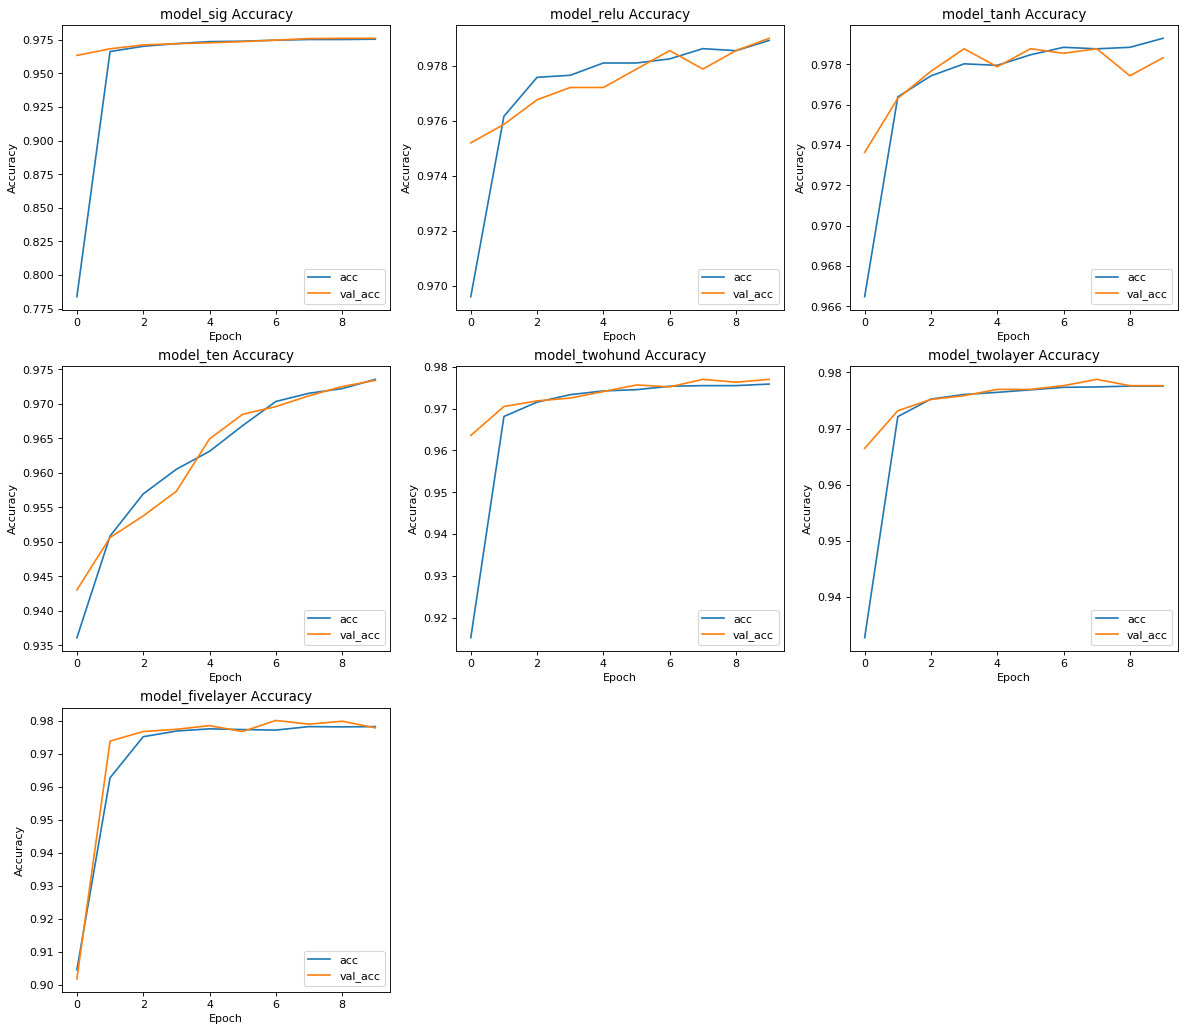

In [90]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
fig.tight_layout()

for index, history in enumerate(historyArr):
    plt.subplot(3,3,index+1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(modelNameArr[index] + " Accuracy")
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['acc', 'val_acc'], loc='lower right')

plt.show()

## Loss of All Models

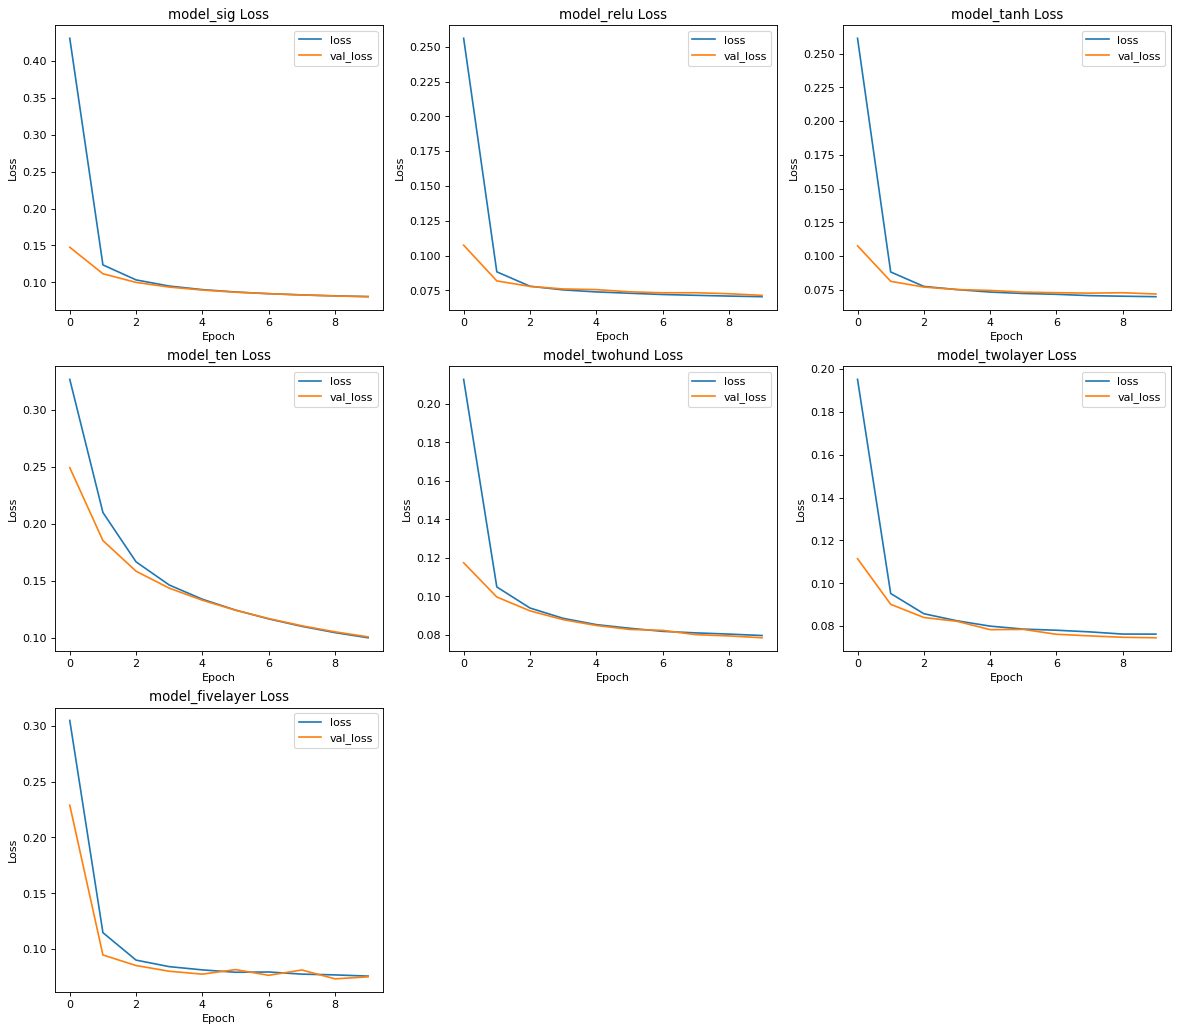

In [91]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
fig.tight_layout()

for index, history in enumerate(historyArr):
    plt.subplot(3,3,index+1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(modelNameArr[index] + " Loss")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper right')

plt.show()

## Final Accuracies of all models after 10 Epochs

In [98]:
for index, model in enumerate(modelArr):
    score, acc = model.evaluate(x_test, y_test, verbose = 0)
    print(modelNameArr[index] + " Accuracy = " + "{:.3%}".format(acc))

model_sig Accuracy = 97.609%
model_relu Accuracy = 97.899%
model_tanh Accuracy = 97.832%
model_ten Accuracy = 97.341%
model_twohund Accuracy = 97.698%
model_twolayer Accuracy = 97.765%
model_fivelayer Accuracy = 97.788%
